<a href="https://colab.research.google.com/github/RaymondBrien/cherry-ml/blob/main/jupyter_notebooks/ColabOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook for Google Collab**

# This notebook is for use in Google Collab only, compiled in a single workflow.

## Objectives
Answer Business requirement 2: Binary Classification using Convolutional Neural Networks

* predict if a given leaf is infected or not judging by the presence of powdery mildew.
* use the CNN to map relationships between features and labels.
* build a binary classifier and generate reports.

## Inputs

* inputs/cherry-leaves-dataset/cherry-leaves/train
* inputs/cherry-leaves-dataset/cherry-leaves/test
* inputs/cherry-leaves-dataset/cherry-leaves/validation
* image shape embeddings pickle file

## Outputs
TODO





---

### ANNOTATE MODEL VERSION

In [1]:
version = 'v5'  # change as needed

Mount drive for backup

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Import regular packages

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [4]:
import os
current_dir = os.getcwd()
current_dir

'/content'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [5]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [6]:
current_dir = os.getcwd()
current_dir

'/'

In [7]:
# manually upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ray989","key":"cbe8066ad38bc961d26ecab0236900b0"}'}

In [8]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=2186f33660ebc2869de27cd1bdb34fe00dad1fe0c3871f1084f2477f9c14a2f8
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [9]:
# allow kaggle.json access
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
! chmod 600 kaggle.json

In [10]:
KaggleDatasetPath = "codeinstitute/cherry-leaves"
DestinationFolder = "inputs/cherry-leaves-dataset"  # creates new dir/dir
! kaggle datasets download -d {KaggleDatasetPath} -p {DestinationFolder}

 98% 54.0M/55.0M [00:01<00:00, 65.9MB/s]
100% 55.0M/55.0M [00:01<00:00, 53.7MB/s]


In [11]:
import zipfile

try:
    with zipfile.ZipFile(DestinationFolder + '/cherry-leaves.zip', 'r') as zip_ref:
        zip_ref.extractall(DestinationFolder)
except Exception as e:
    print(e)


### Set input directory

In [12]:
my_data_dir = 'inputs/cherry-leaves-dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [13]:

file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available, create a new version.')
    pass
else:
    os.makedirs(name=file_path)

### Gather labels

In [14]:
try:
    labels = os.listdir(train_path)
except:
    labels = ['healthy', 'powdery_mildew']

print(f"Project Labels: {labels}")

Project Labels: ['healthy', 'powdery_mildew']


### Load image shape embeddings

In [15]:
import joblib
version_im = 'v1'

try:
    # Import saved image shape embedding pickle file
    image_shape = joblib.load(filename=f"outputs/{version_im}/image_shape.pkl")

except:
    # for google collab
    image_shape = (256, 256, 3)

finally:
    print(image_shape)



(256, 256, 3)


## Validate image files:

In [16]:
# Uncomment if using google collab

def remove_non_image_files(my_data_dir):
    print('Removing non image files...\n')
    image_extension = ('.png', '.jpg', 'jpeg')
    folders = os.listdir(my_data_dir)
    for folder in folders:
        files = os.listdir(f'{my_data_dir}/{folder}')
        # print files
        non_image = []
        image_count = []
        for given_file in files:
            try:
                if not given_file.lower().endswith(image_extension):
                    file_location = f'{my_data_dir}/{folder}/{given_file}'
                    os.remove(file_location) # remove non image file
                    non_image.append(1)
                else:
                    image_count.append(1)
                    pass
            except Exception as e:
                print(e)

        print(f'Folder: {folder} has - {len(image_count)} image files')
        print(f'Folder: {folder} has - {len(non_image)} non image files, which have been removed')

In [17]:
remove_non_image_files('inputs/cherry-leaves-dataset/cherry-leaves')

Removing non image files...

Folder: powdery_mildew has - 2104 image files
Folder: powdery_mildew has - 0 non image files, which have been removed
Folder: healthy has - 2104 image files
Folder: healthy has - 0 non image files, which have been removed


# Split train, val, test sets with dirs

In [18]:
import os
import shutil
import random
import joblib

def split_train_validation_test_images(my_data_dir, train_set_ratio, validation_set_ratio, test_set_ratio):

    # confirm ratios total 1.0
    if train_set_ratio + validation_set_ratio + test_set_ratio != 1.0:
        print('Ratios should total 1.0.')
        print('You entered:\n')
        print(f'Train radio: {train_set_ratio}')
        print(f'Validation radio: {validation_set_ratio}')
        print(f'Test radio: {test_set_ratio}')
        return

    # get classes labels
    labels = os.listdir(my_data_dir)  # expect only folder name
    if 'test' in labels:
        pass
    else:
        try:
            # create train, test folders with classes labels sub-folder
            for folder in ['train', 'validation', 'test']:
                for label in labels:
                    os.makedirs(name=f'{my_data_dir}/{folder}/{label}')

            for label in labels:

                files = os.listdir(f'{my_data_dir}/{label}')
                random.seed(42)
                random.shuffle(files)

                train_set_files_qty = int(len(files) * train_set_ratio)
                validation_set_files_qty = int(len(files) * validation_set_ratio)

                count = 1
                for file_name in files:
                    if count <= train_set_files_qty:
                        # move given file to train set
                        shutil.move(f'{my_data_dir}/{label}/{file_name}',
                                    f'{my_data_dir}/train/{label}/{file_name}')
                    elif count <= (train_set_files_qty + validation_set_files_qty):
                        # move a given file to the validation set
                        shutil.move(f'{my_data_dir}/{label}/{file_name}',
                                    f'{my_data_dir}/validation/{label}/{file_name}')
                    else:
                        # move given file to test set
                        shutil.move(f'{my_data_dir}/{label}/{file_name}',
                                    f'{my_data_dir}/test/{label}/{file_name}')

                    count += 1

                os.rmdir(f'{my_data_dir}/{label}')

        except Exception as e:
            print(e)

    print('Done!')


In [19]:
split_train_validation_test_images(
    my_data_dir='inputs/cherry-leaves-dataset/cherry-leaves',
    train_set_ratio=0.7,
    validation_set_ratio=0.1,
    test_set_ratio=0.2
)

Done!


***

# Review class distribution

* across whole dataset
* per train, test, and validation

* train- healthy: 1472 images

* train- powdery_mildew: 1472 images

* validation- healthy: 210 images

* validation- powdery_mildew: 210 images

* test- healthy: 422 images

* test- powdery_mildew: 422 images

4208 images total
--------


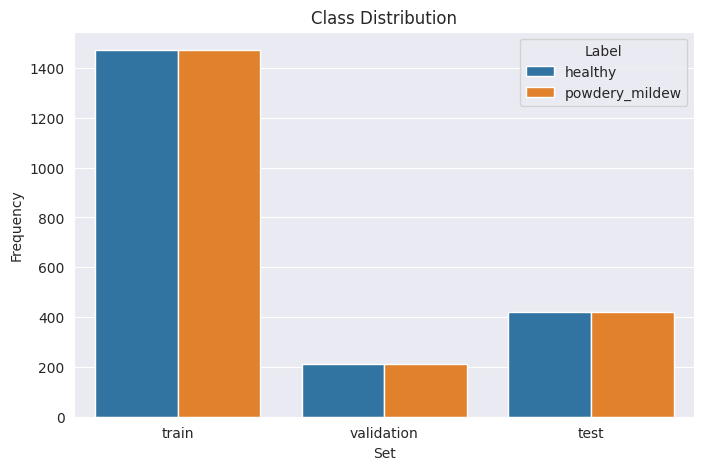



--------
                       Set  Frequency  Percent of DataSet
Label                                                    
healthy              train       1472                35.0
powdery_mildew       train       1472                35.0
healthy         validation        210                 5.0
powdery_mildew  validation        210                 5.0
healthy               test        422                10.0
powdery_mildew        test        422                10.0


In [38]:
df_freq = pd.DataFrame([])
total_images_count = 0


# gather info
for folder in ['train', 'validation', 'test']:
    for label in labels:

        path = my_data_dir + '/' + folder + '/' + label

        image_count = int(len(os.listdir(path)))
        total_images_count += image_count

        # Create a new DataFrame with the data for the current row
        new_row = pd.DataFrame({'Set': [folder], 'Label': [label], 'Frequency': [image_count]})

        # Concatenate the new row to the existing DataFrame
        df_freq = pd.concat([df_freq, new_row], ignore_index=True)

        print(f"* {folder}- {label}: {image_count} images\n")


print(f'{total_images_count} images total')
print('--------')

### plot class distribution
plt.figure(figsize=(8, 5))
sns.set_style('darkgrid')
sns.barplot(x='Set', y='Frequency', hue='Label', data=df_freq, )
            # color='Frequency' alpha="Frequency", edgestyle='Frequency'
plt.title('Class Distribution')
plt.savefig(f'{file_path}/class_distribution.png', bbox_inches='tight', dpi=150)
plt.show()
print('\n')

print('--------')

# confirm percentages of dataset
df_freq.set_index('Label', inplace=True)
df_freq['Percent of DataSet'] = round(df_freq['Frequency'] / total_images_count * 100)

print(df_freq)

We can confirm that train, validation and test set percentages of dataset are split as expected, and that there are equal amounts of both classes (healthy and powdery_mildew) in each set.

***

# Image Augmentation

### Define image data generator, initialize


In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize
augmented_image_data = ImageDataGenerator(rotation_range=30,
                                          width_shift_range=0.15,
                                          height_shift_range=0.15,
                                          brightness_range=[0.8, 1.2],
                                          shear_range=0.1,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Define batch size

In [40]:
batch_size = 20

### Augment TRAINING image dataset


In [41]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True,
                                                     # seed=42,
                                                     )


train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Rescale validation image dataset


In [42]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Rescale test image dataset

In [43]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training images

(20, 256, 256, 3)

--------------


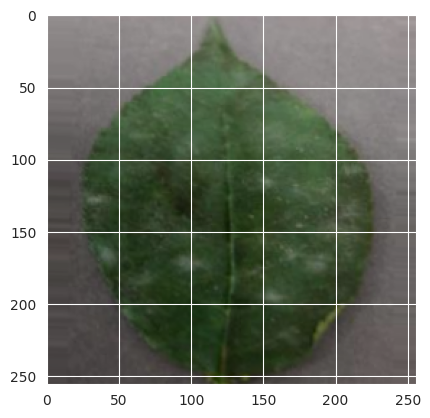

(20, 256, 256, 3)

--------------


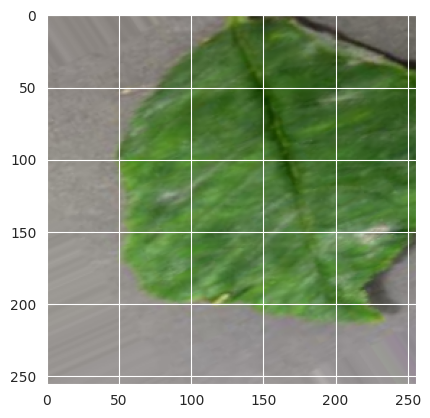

(20, 256, 256, 3)

--------------


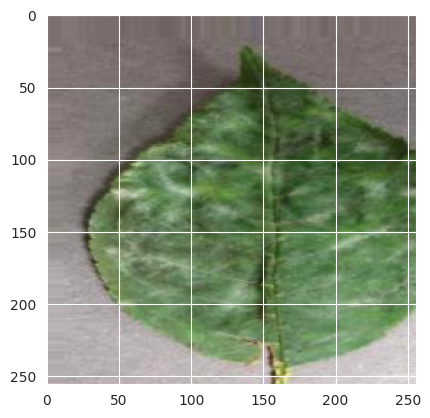

In [44]:
for _ in range(3):
    try:
        img, label = train_set.next()
    except:
        # for google collab functionality
        img, label = next(train_set)

    print(f'{img.shape}\n')  # expect: (20, 256, 256, 3)
    plt.imshow(img[0])
    print('--------------')
    plt.show()


### Plot augmented validation and test images

(20, 256, 256, 3)

--------------


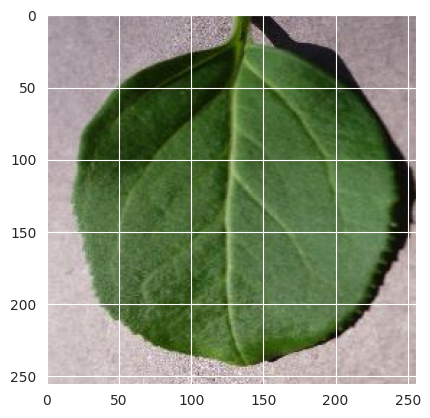

(20, 256, 256, 3)

--------------


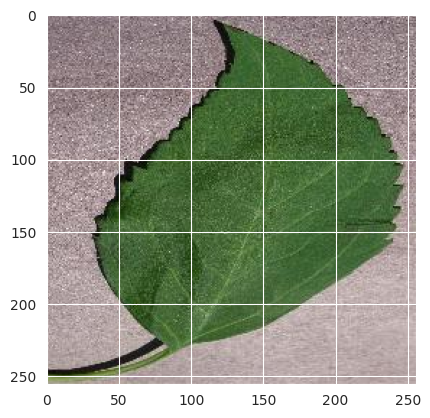

(20, 256, 256, 3)

--------------


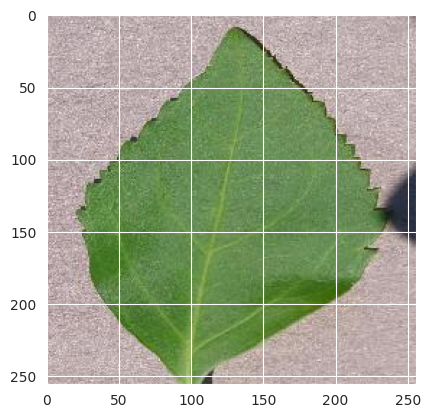

In [45]:
# validation_set
for _ in range(3):
    try:
        img, label = validation_set.next()
    except:
        # for google collab functionality
        img, label = next(validation_set)
    print(f'{img.shape}\n')
    plt.imshow(img[0])
    print('--------------')
    plt.show()



(20, 256, 256, 3)

--------------


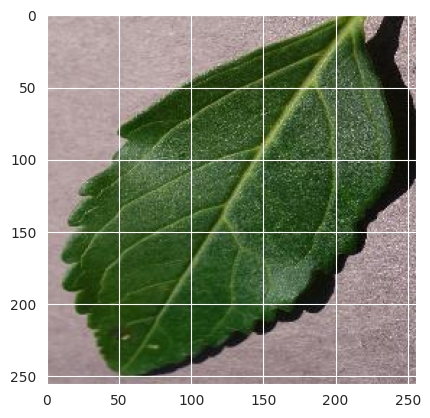

(20, 256, 256, 3)

--------------


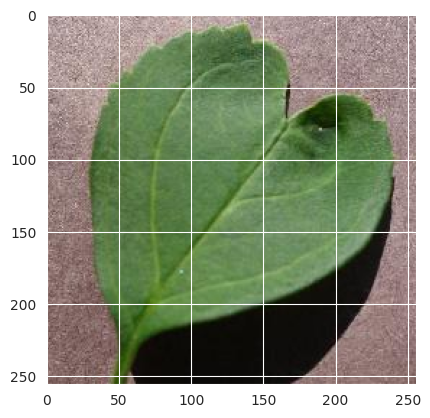

(20, 256, 256, 3)

--------------


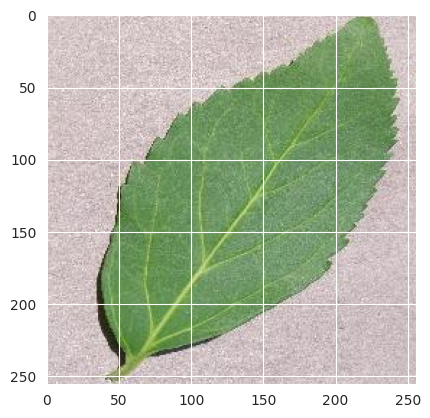

In [46]:
# test set
for _ in range(3):
    try:
        img, label = test_set.next()
    except:
        # for google collab functionality
        img, label = next(test_set)
    print(f'{img.shape}\n')
    plt.imshow(img[0])
    print('--------------')
    plt.show()

###  Observations
Augmented validation and test images have been standardized between 0 to 255 pixels. As you can see, the images are ugmented and are ready to be used for developing and training a CNN model.

### Save class indices

In [47]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v5/class_indices.pkl']

---

# Model Creation

---

### ML Model

* Import model packages

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

* ### Model

In [58]:
def create_tf_model():
    """
    Creates a CNN model for binary classification of leaf images
    TODO add to readme instead:
    Documentation of process:

    v1:
    - 4 convolution layers, c.7m trainable params. Early stopping included. No batch normalisation. Batch size 20.
    - bizarre results with 100% accuracy: concerns of data leakage.

    v2:
    - no early stopping to observe model development over longer period of epochs (25)
    - removed one convolution layer: 4 may have been too complex for the small dataset
        - instead, v2 convolution layer 3 has largest number of filters
    - v2 includes batch normalisation before final dense layer
    - results were unreadable: input ran out of data and interrupted training.
        - steps per epoch needs revision

    V3 :
    - Findings showed that augmented training data was only used on first batch and was not recalled, hense the input ran out of data on subsequent epochs.
    - no early stopping yet - allow full 25 epochs for evaluation first
    - when fitting model, steps per epoch were handled directly by keras (which should be the same as train_set.samples // batch_size), but should call augmentation each time.
        - this showed no input data running out
        - keep early stop

    V4 plans:
        - early stopping
        - did not run out of data now that keras handles steps per epoch
        - batch normalisation before dense layer
        - huge spikes in overfitting (14M params)

    V5:
        - massively reduce complexity of model (max filters)
        - reduce overfitting
        - increase dropout
        - increase batch size
        - reduce early stop patience from 10 to 3

    """
    model = Sequential()

    # Input layer: CONV1
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
        input_shape=image_shape,  # average image shape
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # CONV2
    model.add(Conv2D(filters=12, kernel_size=(3, 3),
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # CONV3
    model.add(Conv2D(filters=8, kernel_size=(3,3),
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy',])

    return model

## Model Summary

In [59]:
summary = create_tf_model().summary(show_trainable=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ conv2d_6 (Conv2D)                   │ (None, 254, 254, 32)         │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_6 (MaxPooling2D)      │ (None, 127, 127, 32)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_7 (Conv2D)                   │ (None, 125, 125, 12)         │         3,468 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_7 (MaxPooling2D)      │ (None, 62, 62, 12)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_8 (Conv2D)                   │ (None, 60, 60, 8)            │           872 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_8 (MaxPooling2D)      │ (None, 30, 30, 8)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten_2 (Flatten)                 │ (None, 7200)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_4 (Dense)                     │ (None, 128)                  │       921,728 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_2 (Dropout)                 │ (None, 128)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_5 (Dense)                     │ (None, 1)                    │           129 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 927,093 (3.54 MB)

 Trainable params: 927,093 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
try:
    plot_model(model, show_shapes=True, to_file=f'model_{version}.png')
except Exception as e:
    print(e)
    pass


name 'model' is not defined


Early Stopping
* Avoid overfitting

In [61]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=3)

***

In [62]:
# TODO remove before submit?
print(f'Train set object: {train_set}')
print(f"Number of samples in training set: {train_set.samples}")
print(f"Number of classes: {len(train_set.classes)}")
print(f"Batch size: {batch_size}")
print(f"Current steps calculation (classes/batch_size): {len(train_set.classes) // batch_size}")
print(f"Correct steps calculation (samples/batch_size): {train_set.samples // batch_size}")
print(f"Number of validation samples: {validation_set.samples}")
print(f"Validation steps per epoch: {validation_set.samples // batch_size}")

Train set object: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7adf368188b0>
Number of samples in training set: 2944
Number of classes: 2944
Batch size: 20
Current steps calculation (classes/batch_size): 147
Correct steps calculation (samples/batch_size): 147
Number of validation samples: 420
Validation steps per epoch: 21


# Fit Model for training

### Save checkpoints

In [65]:
import os

# check if the full path exists
checkpoint_folder = f'/workspace/outputs/{version}/training_checkpoints'

if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)
    print('training checkpoints folder made')

# dynamically include the epoch in checkpoint file name
checkpoint_path = f"{checkpoint_folder}/cp-{{epoch:04d}}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# callback to save model weights per epoch
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1,
                                                 save_weights_only=True,
                                                 save_freq='epoch',
                                                 monitor='accuracy',
                                                 save_best_only=True)


Brief untrained model evaluation

In [67]:
loss, acc = create_tf_model().evaluate(test_set, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc)) # expect c.50% accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 - 20s - 468ms/step - accuracy: 0.4419 - loss: 0.7075
Untrained model, accuracy: 44.19%


Add CSV logger for history access in case of training runtime errors

In [68]:
from keras.callbacks import CSVLogger

# From here on you can treat the data stored in log_data just as you would by loading it from K.history.
# https://keras.io/api/callbacks/csv_logger/
history_csv_logger = CSVLogger('training.log', separator=',', append=False)


In [69]:
EPOCHS = 25

try:
    model = create_tf_model()
    model.fit(train_set,
            epochs=EPOCHS,
            # TODO remove? steps_per_epoch=None, # None is equal to the number of samples in your dataset divided by the batch size
            steps_per_epoch = len(train_set.classes) // batch_size,
            validation_data=validation_set,
            # TODO remove? validation_steps=None,  #  validation will run until the validation_data dataset is exhausted
            callbacks=[early_stop, cp_callback, history_csv_logger],
            verbose=1,
            )
except Exception as e:
    print(e + '\n')

    # load latest weights
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)

    print('Model restored! Continuing...')
    # continue model training
    model.fit(train_set,
            epochs=EPOCHS,
            # TODO remove? steps_per_epoch=None, # None is equal to the number of samples in your dataset divided by the batch size
            steps_per_epoch = len(train_set.classes) // batch_size,
            validation_data=validation_set,
            # TODO remove? validation_steps=None,
            callbacks=[early_stop, cp_callback, history_csv_logger],
            verbose=1,
            )


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6998 - loss: 0.5305
Epoch 1: accuracy improved from -inf to 0.82216, saving model to /workspace/outputs/v5/training_checkpoints/cp-0001.weights.h5
147/147 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.7006 - loss: 0.5295 - val_accuracy: 0.9976 - val_loss: 0.0448
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 3:03 1s/step - accuracy: 0.8500 - loss: 0.2713

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: accuracy improved from 0.82216 to 0.85000, saving model to /workspace/outputs/v5/training_checkpoints/cp-0002.weights.h5
147/147 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.8500 - loss: 0.2713 - val_accuracy: 0.9952 - val_loss: 0.0436
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9452 - loss: 0.1457
Epoch 3: accuracy improved from 0.85000 to 0.95383, saving model to /workspace/outputs/v5/training_checkpoints/cp-0003.weights.h5
147/147 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9452 - loss: 0.1456 - val_accuracy: 0.9452 - val_loss: 0.1029
Epoch 4/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 4:49 2s/step - accuracy: 0.9500 - loss: 0.0864
Epoch 4: accuracy did not improve from 0.95383
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9500 - loss: 0.0864 - val_accuracy: 0.9643 - val_loss: 0.0695
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9618 - loss: 0.1173
Epoch 5: accuracy did not improve from 0.95383
147/147 ━━━━━━━━━━━━━━━━━━━━ 288

### Save model

In [70]:
try:
    model.save(f'outputs/{version}/cherry-tree-model.h5')
    print('model saved!')
except Exception as e:
    print(e)

model saved!


***

# Evaluate Model Performance

Model learning curve

In [71]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.metrics import confusion_matrix, classification_report

# def extract_performance_from_history(model):
#     """
#     Extract and analyze performance metrics from model training history

#     Parameters:
#     - model: Trained Keras model
#     - history: Model training history object

#     Returns:
#     - Dictionary of performance metrics
#     """
#     # Extract metrics from history
#     history = model.history.history

#     performance_metrics = {
#         'training': {
#             'loss': history.get('loss', []),
#             'accuracy': history.get('accuracy', []),
#             'val_loss': history.get('val_loss', []),
#             'val_accuracy': history.get('val_accuracy', [])
#         }
#     }

#     # Calculate best epoch and corresponding metrics
#     best_train_accuracy = max(performance_metrics['training']['accuracy'])
#     best_val_accuracy = max(performance_metrics['training']['val_accuracy'])
#     best_train_loss = min(performance_metrics['training']['loss'])
#     best_val_loss = min(performance_metrics['training']['val_loss'])

#     performance_metrics['best_metrics'] = {
#         'best_train_accuracy': best_train_accuracy,
#         'best_val_accuracy': best_val_accuracy,
#         'best_train_loss': best_train_loss,
#         'best_val_loss': best_val_loss
#     }

#     return performance_metrics

# def plot_training_history(model):
#     """
#     Create plots for training and validation metrics

#     Parameters:
#     - history: Model training history object

#     Returns:
#     - Matplotlib figure with subplots
#     """
#     import matplotlib.pyplot as plt

#     history = model.history

#     plt.figure(figsize=(12, 4))

#     # Plot training & validation accuracy values
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('Model Accuracy')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='lower right')
#     plt.savefig(f'outputs/{version}/training_accuracy.png', bbox_inches='tight', dpi=600)

#     # Plot training & validation loss values
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='upper right')

#     plt.tight_layout()
#     plt.savefig(f'outputs/{version}/training_history.png', bbox_inches='tight', dpi=600)
#     return plt

# def print_model_summary(model):
#     """
#     Print a detailed summary of the model architecture

#     Parameters:
#     - model: Keras model
#     """
#     # Capture model summary as a string
#     from io import StringIO
#     import sys

#     # Redirect stdout to capture model summary
#     old_stdout = sys.stdout
#     model_summary = StringIO()
#     sys.stdout = model_summary

#     model.summary()

#     # Restore stdout and get the summary
#     sys.stdout = old_stdout
#     summary_text = model_summary.getvalue()

#     print("Model Architecture Summary:")
#     print(summary_text)

# # Example usage:
# def comprehensive_model_analysis(model, train_set, validation_set, test_set, labels):
#     """
#     Provide comprehensive analysis of model performance

#     Parameters:
#     - model: Trained Keras model
#     - history: Model training history
#     - train_set, validation_set, test_set: Data generators
#     - labels: List of class labels
#     """
#     # 1. Print model summary
#     print(model.summary())

#     # 2. Extract performance metrics
#     performance_metrics = extract_performance_from_history(model)

#     # 3. Print performance metrics
#     print("\n--- Performance Metrics ---")
#     for metric, value in performance_metrics['best_metrics'].items():
#         print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

#     # 4. Plot training history
#     plt = plot_training_history(model)
#     plt.show()

#     # 5. TODO Generate confusion matrices
#     # print("\n--- Confusion Matrices ---")
#     # clf_performance(model, train_set, validation_set, test_set, labels)




Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 12)        │           3,468 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 8)           │             872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         921,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,781,281 (10.61 MB)

 Trainable params: 927,093 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,854,188 (7.07 MB)

None

--- Performance Metrics ---
Best Train Accuracy: 1.0000
Best Val Accuracy: 1.0000
Best Train Loss: 0.0021
Best Val Loss: 0.0057


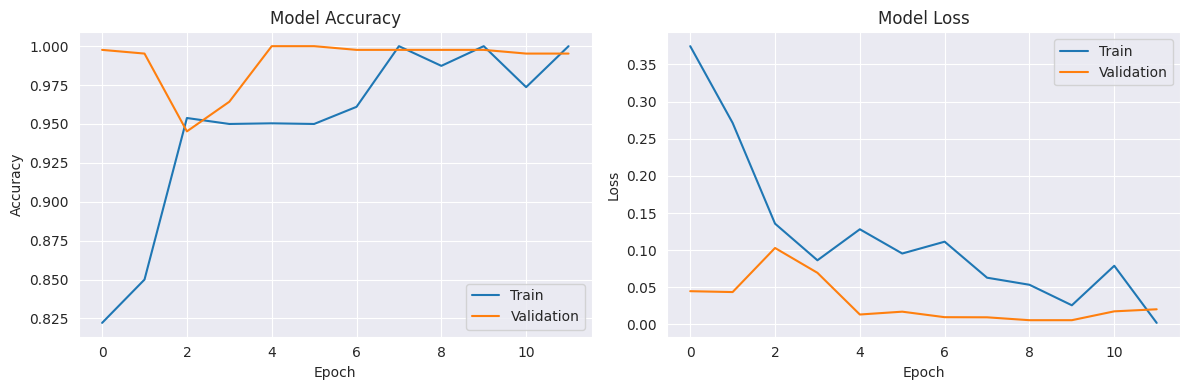

In [72]:
# comprehensive_model_analysis(model, train_set, validation_set, test_set, labels)

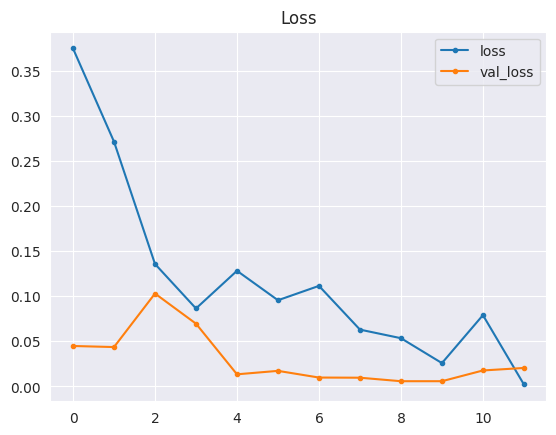

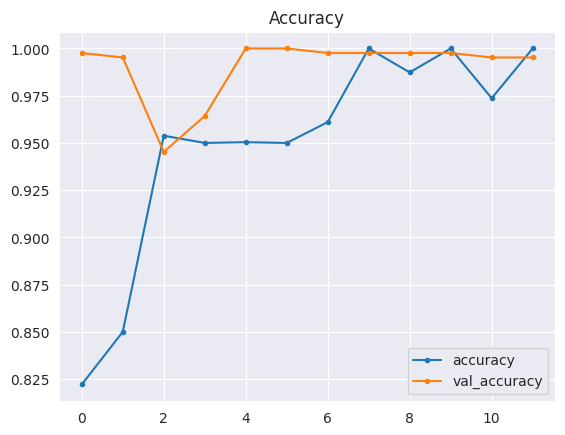

In [73]:
# TODO evaluate if this or above is better
losses = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()


print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Evaluate and save

In [74]:
from keras.models import load_model
model = load_model(f'{file_path}/cherry-tree-model.h5')

In [75]:
try:
    eval1 = model.evaluate(test_set)
    evaluation_train = model.evaluate(train_set)
    evaluation_val = model.evaluate(validation_set)
except Exception as e:
    eval1 = model.evaluate(test_set)  # evaluate on test set only
    print(e)
    pass

43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 482ms/step - accuracy: 0.9956 - loss: 0.0188
148/148 ━━━━━━━━━━━━━━━━━━━━ 126s 850ms/step - accuracy: 0.9878 - loss: 0.0326
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - accuracy: 0.9983 - loss: 0.0080


Save evaluations

In [76]:
joblib.dump(value=eval1,filename=f"outputs/{version}/test-evaluation.pkl")
joblib.dump(value=evaluation_train,filename=f"outputs/{version}/train-evaluation.pkl")
joblib.dump(value=evaluation_val,filename=f"outputs/{version}/val-evaluation.pkl")

['outputs/v5/val-evaluation.pkl']

Save backup model to drive

In [77]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r outputs/{version} /content/drive/MyDrive/{version}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Run Live Prediction

Load image as PIL

Image shape: (256, 256), Image mode: RGB


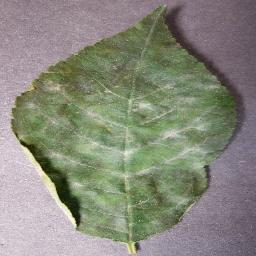

In [78]:
from tensorflow.keras.preprocessing import image

pointer = 66  # TODO change to random within length of dir
label = labels[1]  # select Uninfected or Parasitised # TODO change to random (0 or 1) and print image class too

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert prediction image to array for prediction

In [79]:
pred_img = image.img_to_array(pil_image)
pred_img = np.expand_dims(pred_img, axis=0)/255
print(pred_img.shape)

(1, 256, 256, 3)


Predict class probability on test image

In [80]:
pred_proba = model.predict(pred_img)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]  # define binary boundary

if pred_class == target_map[0]:
  pred_proba = 1 - pred_proba

print(f'Prediction: {pred_class}\nConfidence: {pred_proba*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Prediction: powdery_mildew
Confidence: 100.00%


## Save backup files to drive

Save tf version used in notebook to file

In [81]:
tf_version = tf.__version__
tf_version

joblib.dump(value=tf_version,filename=f"outputs/{version}/tf_version.pkl")

['outputs/v5/tf_version.pkl']

In [82]:
!pip freeze > outputs/{version}/colab_requirements.txt

Reconfirm all files saved in backup

In [83]:
from google.colab import drive
drive.mount('/content/drive')


!cp -r outputs/{version} /content/drive/MyDrive/{version}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***